## Importing library

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

## Reading data

In [3]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [6]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [7]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


## Merge in store info

In [8]:
stores = pd.read_csv("data/stores.csv")
train = train.merge(stores, how='left', on='Store')
test = test.merge(stores, how='left', on='Store')

## Create indexes for submission

In [9]:
train["Id"] = train["Store"].astype(str) + "_" + train["Dept"].astype(str) + "_" + train["Date"].astype(str)
train = train.set_index("Id")
test["Id"] = test["Store"].astype(str) + "_" + test["Dept"].astype(str) + "_" + test["Date"].astype(str)
test = test.set_index("Id")

## Also make an index by store_dept to split up the dataset

In [11]:
train["Index"] = train["Store"].astype(str) + "_" + train["Dept"].astype(str)
test["Index"] = test["Store"].astype(str) + "_" + test["Dept"].astype(str)

## Add column for year

In [12]:
train["Year"] = pd.to_datetime(train["Date"], format="%Y-%m-%d").dt.year
test["Year"] = pd.to_datetime(test["Date"], format="%Y-%m-%d").dt.year

## Add column for day

In [13]:
train["Day"] = pd.to_datetime(train["Date"], format="%Y-%m-%d").dt.day
test["Day"] = pd.to_datetime(test["Date"], format="%Y-%m-%d").dt.day

## Add column for days to next Christmas

In [14]:
train["Days to Next Christmas"] = (pd.to_datetime(train["Year"].astype(str)+"-12-31", format="%Y-%m-%d") -
                                   pd.to_datetime(train["Date"], format="%Y-%m-%d")).dt.days.astype(int)
test["Days to Next Christmas"] = (pd.to_datetime(test["Year"].astype(str) + "-12-31", format="%Y-%m-%d") -
                                   pd.to_datetime(test["Date"], format="%Y-%m-%d")).dt.days.astype(int)

## Create store_dept dictionaries

In [15]:
print("Splitting the datasets into subsets...")
traindict = {}
testdict = {}
for index in set(test["Index"].tolist()):
    traindict[index] = train[train["Index"]==index]
    testdict[index] = test[test["Index"]==index]


Splitting the datasets into subsets...


## Function for formatting each dataset

In [16]:
def featureprep(train, test, dropaxis, splitset):
    if splitset == True:
        def xdums(df):
            dums = pd.get_dummies(pd.to_datetime(df["Date"], format="%Y-%m-%d").dt.week)
            dums.columns = map(lambda x: "Week_" + str(x), dums.columns.values)
            return dums
    else:
        def xdums(df):
            dums = pd.get_dummies(df["Store"])
            dums = dums.set_index(df.index)
            dums.columns = map(lambda x: "Store_" + str(x), dums.columns.values)
            out = dums
            dums = pd.get_dummies(df["Dept"])
            dums.columns = map(lambda x: "Dept_" + str(x), dums.columns.values)
            out = out.join(dums)
            dums = pd.get_dummies(df["Type"])
            dums.columns = map(lambda x: "Type_" + str(x), dums.columns.values)
            out = out.join(dums)
            dums = pd.get_dummies(pd.to_datetime(df["Date"], format="%Y-%m-%d").dt.week)
            dums.columns = map(lambda x: "Week_" + str(x), dums.columns.values)
            out = out.join(dums)
            return out
    train_x = xdums(train).join(train[["IsHoliday", "Size", "Year", "Day", "Days to Next Christmas"]])
    test_x = xdums(test).join(test[["IsHoliday", "Size", "Year", "Day", "Days to Next Christmas"]])
    train_x = train_x.dropna(axis=dropaxis)
    test_x = test_x.dropna(axis=dropaxis)
    train_y = train.dropna(axis=dropaxis)["Weekly_Sales"]
    for feature in train_x.columns.values:
        if feature not in test_x.columns.values:
            train_x = train_x.drop(feature, axis=1)
    for feature in test_x.columns.values:
        if feature not in train_x.columns.values:
            test_x = test_x.drop(feature, axis=1)
    return train_x, train_y, test_x

## Define estimator

In [17]:
estimator = GradientBoostingRegressor(loss="huber")

## Function for returning estimates

In [18]:
def estimates(train, test, splitset):
    train_x, train_y, test_x = featureprep(train, test, 1, splitset)
    estimator.fit(train_x, train_y)
    out = pd.DataFrame(index=test_x.index)
    out["Weekly_Sales"] = estimator.predict(test_x)
    out["Id"] = out.index
    plot = pd.DataFrame(index=train_x.index)
    plot["Weekly_Sales"] = train_y
    plot["Weekly_Predicts"] = estimator.predict(train_x)
    plot["Date"] = plot.index.str.split("_").str[-1]
    plot = plot.groupby("Date")[["Weekly_Sales", "Weekly_Predicts"]].sum()
    return out, plot

## Run the individual store-departments models

In [19]:
print("Beginning main model...")
out = pd.DataFrame()
plot = pd.DataFrame()
count = 0
for key in testdict.keys():
    count += 1
    try:
        ot, pt = estimates(traindict[key], testdict[key], True)
        out = pd.concat([out, ot])
        plot = pd.concat([plot, pt])
    except:
        print("No training data available for {}".format(key))
    if count%20 == 0:
        print("Modeling... {}%".format(list(testdict.keys()).index(key)/len(testdict.keys())*100))

Beginning main model...
Modeling... 0.5995582202587567%
Modeling... 1.230672136320606%
Modeling... 1.861786052382455%
Modeling... 2.4928999684443043%
Modeling... 3.1240138845061534%
Modeling... 3.7551278005680024%
Modeling... 4.3862417166298515%
Modeling... 5.017355632691701%
Modeling... 5.64846954875355%
Modeling... 6.2795834648154%
Modeling... 6.910697380877248%
Modeling... 7.541811296939098%
Modeling... 8.172925213000946%
Modeling... 8.804039129062796%
Modeling... 9.435153045124645%
Modeling... 10.066266961186495%
Modeling... 10.697380877248342%
Modeling... 11.328494793310192%
Modeling... 11.959608709372041%
Modeling... 12.590722625433893%
Modeling... 13.22183654149574%
Modeling... 13.85295045755759%
Modeling... 14.484064373619438%
Modeling... 15.115178289681289%
Modeling... 15.746292205743137%
Modeling... 16.377406121804984%
Modeling... 17.008520037866834%
No training data available for 18_43
Modeling... 17.639633953928683%
Modeling... 18.270747869990533%
Modeling... 18.90186178605

## Run a model of all the data to fill in anything that was NA

In [20]:
print("Creating giant model to fill in for those pesky missing datas... Probably going to take a while.")
sout, splot = estimates(train, test, False)
sout = sout.join(out, how="left", lsuffix="_Backup")
sout["Weekly_Sales"] = sout["Weekly_Sales"].fillna(sout["Weekly_Sales_Backup"])

Creating giant model to fill in for those pesky missing datas... Probably going to take a while.


### Format for submission

In [21]:
sout["Id"] = sout["Id"].fillna(sout["Id_Backup"])
sout = sout.drop(["Weekly_Sales_Backup", "Id_Backup"], axis=1)
splot = splot.join(plot, how="left", lsuffix="_Backup")
splot["Weekly_Sales"] = splot["Weekly_Sales"].fillna(splot["Weekly_Sales_Backup"])
splot["Weekly_Predicts"] = splot["Weekly_Predicts"].fillna("Weekly_Predicts_Backup")
splot = splot.drop(["Weekly_Sales_Backup", "Weekly_Predicts_Backup"], axis=1)

C:\Users\Mayur Maheshwari\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


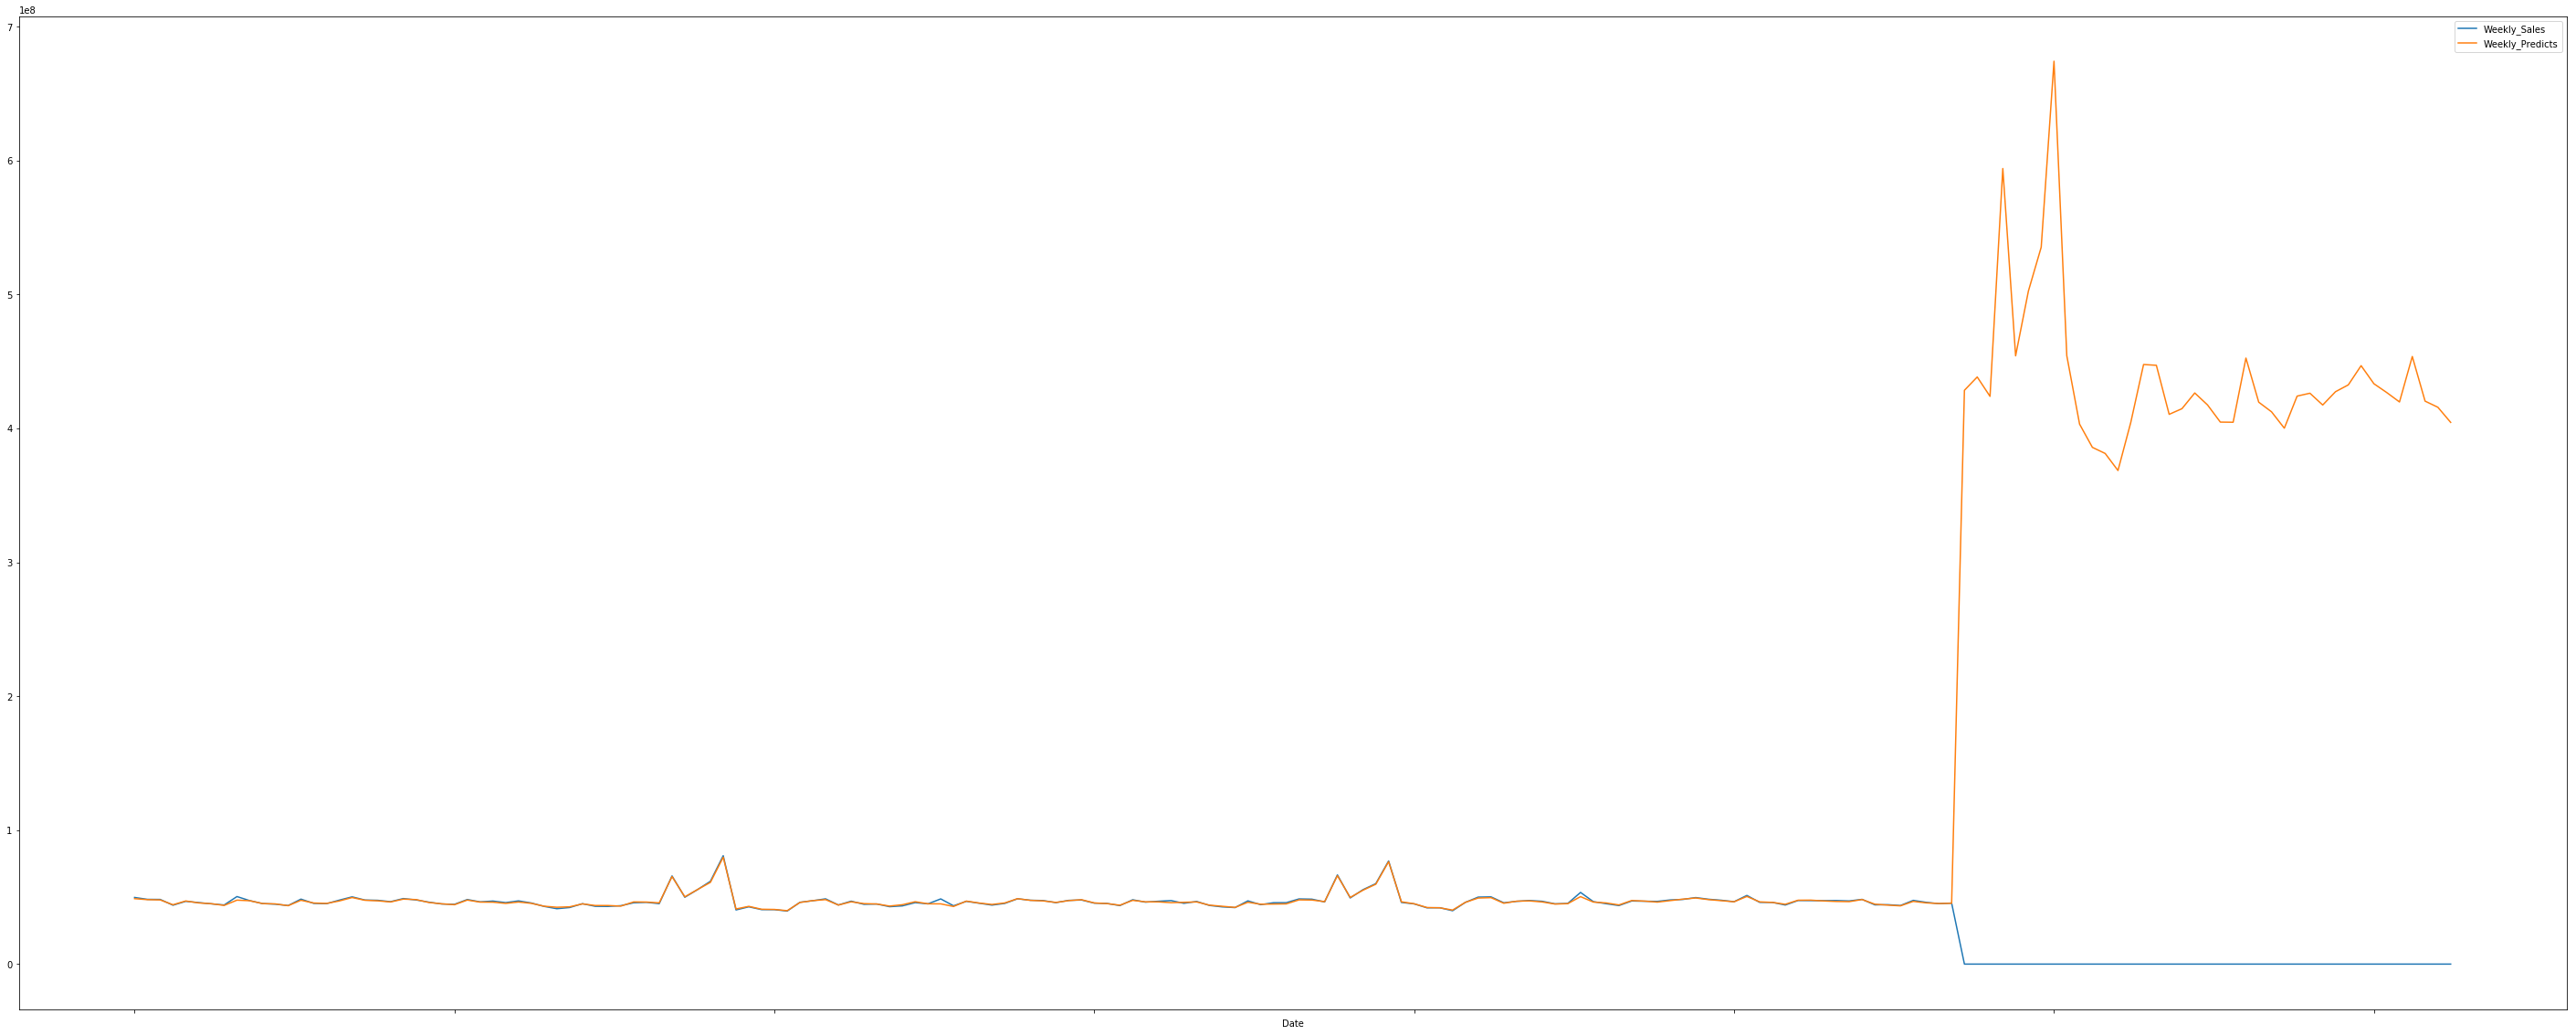

In [30]:
sout["Date"] = sout.index.str.split("_").str[-1]
plot = sout.groupby("Date")[["Weekly_Sales"]].sum()
plot["Weekly_Predicts"] = plot["Weekly_Sales"]
plot = plot.drop("Weekly_Sales", axis=1)
splot = splot.append(plot)
splot = splot.reset_index().groupby("Date")[["Weekly_Sales", "Weekly_Predicts"]].sum()
splot.plot(figsize=(50,20))